## 1. 환경 설정

`(1) Env 환경변수`

In [9]:
from dotenv import load_dotenv
load_dotenv()

True

## 2. prepare_context
- 학생 프로필 정보 (목표 대학, 계열)
- 최근 대화 내역 (학생 ↔ 선생님 대화 로그 일부)

두 가지를 받아서 질문 분석(analyze_question) 단계에 넘길 “맥락 포함 질문”을 생성

In [10]:
from typing import TypedDict, List, Dict

# ======================================
# LangGraph 상태 구조 정의 (QAState)
# ======================================
# TypedDict: Python의 타입 힌트를 위한 딕셔너리 구조
# - LangGraph의 모든 노드가 이 상태 구조를 공유하며 데이터를 전달함
# - 각 노드는 필요한 필드를 읽고, 업데이트된 필드를 반환함
# ======================================
class QAState(TypedDict):
    # 1️⃣ 사용자 입력 정보
    question: str                           # 학생의 질문 (예: "중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?")
    student_profile: Dict[str, str]         # 학생 프로필 정보 (예: {"target_university": "중앙대학교", "track": "이과"})
    recent_dialogues: List[Dict[str, str]]  # 최근 대화 내역 (예: [{"role": "student", "message": "..."}, {"role": "teacher", "message": "..."}])
    
    # 2️⃣ 컨텍스트 (prepare_context 노드에서 생성)
    context: str                            # 학생 프로필 + 대화 내역 + 질문을 종합한 컨텍스트 문자열
    
    # 3️⃣ 질문 분류 및 FAQ (현재 통합 에이전트에서는 미사용)
    category: str                           # 질문 카테고리 (예: "입시일정", "시험과목", "모집요강")
    faq_answer: str                         # FAQ 검색 결과 (자주 묻는 질문에 대한 사전 답변)
    
    # 4️⃣ 검색 결과
    search_results: List[Dict]              # 검색된 문서 리스트 (RAG 검색 결과)
    
    # 5️⃣ 답변 생성
    candidate_answer: str                   # 후보 답변 (최종 답변 전 임시 답변)
    evaluation: str                         # 답변 평가 결과 (품질 체크용)
    final_answer: str                       # 최종 답변 (학생에게 제공할 답변)
    
    # 6️⃣ 출처 정보
    sources: List[str]                      # 답변의 출처 리스트 (문서 ID, URL 등)


In [11]:
def prepare_context(state: QAState) -> QAState:
    """
    학생 프로필과 최근 대화 내역을 종합하여 context 생성
    """
    # 학생 프로필 불러오기
    profile = state.get("student_profile", {})
    target_uni = profile.get("target_university", "미지정")
    track = profile.get("track", "계열 미지정")

    # 최근 대화 내역 가져오기 (학생과 선생님 5개 정도)
    dialogues = state.get("recent_dialogues", [])
    dialogue_summary = " ".join(
        [f"{d['role']}: {d['message']}" for d in dialogues[-5:]]
    )

    # 질문과 맥락 결합
    state["context"] = (
        f"[학생 프로필] 목표 대학: {target_uni}, 계열: {track}\n"
        f"[최근 대화 요약] {dialogue_summary}\n"
        f"[학생 질문] {state['question']}"
    )

    return state


In [12]:
# 초기 상태 정의
init_state: QAState = {
    "question": "혹시 중앙대학교 이과는 어떤 과목을 준비해야 하나요?",
    "student_profile": {
        "target_university": "중앙대학교",
        "track": "이과"
    },
    "recent_dialogues": [
        {"role": "student", "message": "아직 편입 공부를 시작하진 않았습니다."},
        {"role": "teacher", "message": "언제부터 공부 시작할 계획인가요?"},
        {"role": "student", "message": "다음 주부터 시작할 생각인데 정해지면 이야기해드릴게요."},
        {"role": "teacher", "message": "네 알겠습니다."},
        {"role": "student", "message": "혹시 중앙대학교 이과는 어떤 과목을 준비해야 하나요?"}
    ],
    "context": "",
    "category": "",
    "faq_answer": "",
    "search_results": [],
    "candidate_answer": "",
    "evaluation": "",
    "final_answer": "",
    "sources": []
}

# prepare_context 실행
updated_state = prepare_context(init_state)

print("=== 준비된 Context ===")
print(updated_state["context"])


=== 준비된 Context ===
[학생 프로필] 목표 대학: 중앙대학교, 계열: 이과
[최근 대화 요약] student: 아직 편입 공부를 시작하진 않았습니다. teacher: 언제부터 공부 시작할 계획인가요? student: 다음 주부터 시작할 생각인데 정해지면 이야기해드릴게요. teacher: 네 알겠습니다. student: 혹시 중앙대학교 이과는 어떤 과목을 준비해야 하나요?
[학생 질문] 혹시 중앙대학교 이과는 어떤 과목을 준비해야 하나요?


## ⚙️ 서버 환경 설정 (Gemini API 사용)

### 필요한 환경 변수:
```bash
export GOOGLE_API_KEY="your_google_api_key_here"
export TAVILY_API_KEY="your_tavily_api_key_here"
```

### 주의사항:
- ⚠️ **기존 Chroma DB 여부 확인**: 기존에 `chroma_guideline` 폴더가 있다면 굳이 색인을 하지 않고 스킵함.
- 문제가 있다면 `chroma_guideline` 폴더 삭제 후 재실행하면 자동으로 새로 생성됨


### 3-1 검색 tool 설정 
### 도구 1. Guideline_search
- 가이드라인DB 내에서 검색
### 도구 2. web_search
- 웹 검색 

In [ ]:
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings  #
from langchain_core.documents import Document
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_core.tools import tool
from typing import List
import pandas as pd
import os


# ======================================================
# 1️⃣ Google Gemini Embeddings 초기화 (서버 환경 대응)
# ======================================================
# - Ollama 대신 Google Gemini API 사용
# - 필요: GOOGLE_API_KEY 환경 변수 설정
# - 모델: text-embedding-004 (최신 임베딩 모델)
print("🚀 Google Gemini Embeddings 모델 초기화 중...")
embeddings_model = GoogleGenerativeAIEmbeddings(
    model="models/text-embedding-004",  # Gemini 임베딩 모델
    task_type="retrieval_document"      # 문서 검색 최적화
)


# ======================================================
# 2️⃣ Chroma DB 생성 또는 불러오기
# ======================================================
persist_dir = "./chroma_guideline"
collection_name = "guideline_db"

if not os.path.exists(persist_dir):
    print("📌 최초 실행: CSV에서 GuidelineDB 생성 중...")
    df = pd.read_csv("GuidelineDB.csv", encoding="utf-8")

    # CSV를 Document 리스트로 변환
    documents = []
    for _, row in df.iterrows():
        documents.append(
            Document(
                page_content=row["question"],
                metadata={
                    "answer": row["answer"],
                    "category": row.get("category", ""),
                    "source": "guidelineDB",
                    "source_name": "GuidelineDB",
                    "source_detail": row.get("출처", "출처 미기재"),
                }
            )
        )

    # 한 번에 DB 생성 및 저장
    guideline_db = Chroma.from_documents(
        documents=documents,
        embedding=embeddings_model,
        collection_name=collection_name,
        persist_directory=persist_dir
    )
    print("✅ GuidelineDB 생성 완료 (Chroma persisted).")
else:
    print("📌 기존 GuidelineDB 불러오는 중...")
    guideline_db = Chroma(
        collection_name=collection_name,
        persist_directory=persist_dir,
        embedding_function=embeddings_model
    )
    print("✅ GuidelineDB 로드 완료.")


# ======================================================
# 3️⃣ Reranker 모델 설정
# ======================================================
print("🧠 Reranker 모델 로드 중 (BAAI/bge-reranker-v2-m3)...")
rerank_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")
cross_reranker = CrossEncoderReranker(model=rerank_model, top_n=2)  # ✅ 상위 2개만 선정
print("✅ Reranker 로드 완료.")


# ======================================================
# 4️⃣ 하이브리드 검색 함수 (키워드 + 벡터)
# ======================================================
def hybrid_search(query: str, k: int = 2) -> List[Document]:  # ✅ 기본값 2개로 변경
    """
    🎯 하이브리드 검색: 키워드 매칭 + 벡터 유사도 + Reranker
    
    단계:
    1. 키워드 추출 (2글자 이상)
    2. 키워드가 포함된 문서 필터링
    3. 필터링된 문서에 대해 벡터 유사도 계산
    4. Reranker로 최종 순위 결정
    5. 키워드 매칭 실패 시 순수 벡터 검색으로 폴백
    """
    print(f"   🔍 하이브리드 검색 시작...")
    
    # 1️⃣ 키워드 추출
    keywords = [word for word in query.split() if len(word) >= 2]
    print(f"   📌 추출된 키워드: {keywords}")
    
    # 2️⃣ DB에서 모든 문서 가져오기
    collection = guideline_db._collection
    all_result = collection.get(include=['documents', 'metadatas'])
    all_contents = all_result.get('documents', [])
    all_metadatas = all_result.get('metadatas', [])
    
    # 3️⃣ 키워드 매칭 점수 계산
    keyword_matches = []
    for i, content in enumerate(all_contents):
        score = sum(1 for kw in keywords if kw.lower() in content.lower())
        
        if score > 0:
            keyword_matches.append({
                'content': content,
                'metadata': all_metadatas[i] if i < len(all_metadatas) else {},
                'score': score
            })
    
    print(f"   ✅ 키워드 매칭 문서: {len(keyword_matches)}개")
    
    # 4️⃣ 키워드 매칭된 문서 처리
    if len(keyword_matches) > 0:
        # 점수순 정렬 후 상위 50개
        keyword_matches.sort(key=lambda x: x['score'], reverse=True)
        top_matches = keyword_matches[:min(50, len(keyword_matches))]
        
        # Document 객체로 변환
        candidate_docs = [
            Document(
                page_content=match['content'],
                metadata=match['metadata']
            )
            for match in top_matches
        ]
        
        # Reranker로 최종 순위
        print(f"   🧠 Reranker로 상위 {k}개 선정...")
        final_docs = cross_reranker.compress_documents(candidate_docs, query)
        return final_docs[:k]
    
    # 5️⃣ 키워드 매칭 실패 → 순수 벡터 검색
    print(f"   ⚠️ 키워드 매칭 0개, 벡터 검색으로 폴백")
    vector_results = guideline_db.similarity_search(query, k=50)
    final_docs = cross_reranker.compress_documents(vector_results, query)
    return final_docs[:k]


# ======================================================
# 5️⃣ GuidelineDB 검색 도구 (하이브리드 방식)
# ======================================================
@tool
def guideline_search(query: str) -> List[Document]:
    """
    GuidelineDB에서 하이브리드 검색합니다.
    키워드 매칭 + 벡터 유사도 + Reranker 조합
    """
    print(f"\n🔍 [GuidelineDB Hybrid Search] 쿼리: {query}")
    
    # 하이브리드 검색 실행 (상위 2개만)
    docs = hybrid_search(query, k=2)  # ✅ 5개 → 2개로 변경
    
    if len(docs) == 0:
        print("❗ 검색 결과 없음")
        return [Document(page_content="관련 정보를 찾을 수 없습니다.", metadata={"source": "guidelineDB"})]
    
    print(f"📄 최종 검색 결과: {len(docs)}개")
    
    # 결과 포맷팅
    formatted_docs = []
    for i, d in enumerate(docs, 1):
        q = d.page_content.strip()
        a = d.metadata.get("answer", "").strip()
        src_detail = d.metadata.get("source_detail", "출처 미기재")
        
        print(f"   ▶ [{i}] {q[:60]}... (출처: {src_detail})")
        
        formatted_docs.append(
            Document(
                page_content=f"Q: {q}\nA: {a}",
                metadata={
                    "source": "guidelineDB",
                    "source_name": "GuidelineDB",
                    "source_detail": src_detail
                }
            )
        )
    
    print("✅ 검색 완료")
    return formatted_docs


# ======================================================
# 6️⃣ 웹 검색 도구
# ======================================================
print("🌐 Tavily Web Search Retriever 초기화 중...")
web_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker,
    base_retriever=TavilySearchAPIRetriever(k=10),
)
print("✅ Web Retriever 준비 완료.")


@tool
def web_search(query: str) -> List[Document]:
    """
    데이터베이스에 없는 정보 또는 최신 정보를 웹에서 검색합니다.
    (검색된 문서의 제목, URL, 내용 요약, 출처를 포함하여 반환)
    """
    print(f"\n🌐 [Web Search] 쿼리 실행: {query}")
    docs = web_retriever.invoke(query)
    formatted_docs = []

    if len(docs) == 0:
        print("❗ 웹 검색 결과 없음")
        return [Document(page_content="관련 정보를 찾을 수 없습니다.", metadata={"source": "web search"})]

    print(f"📄 검색된 문서 수: {len(docs)}")

    for i, doc in enumerate(docs):
        # 안전하게 URL과 제목 추출
        source_url = doc.metadata.get("source", "URL 미기재")
        title = doc.metadata.get("title", "제목 없음")
        snippet = doc.page_content[:400]

        print(f"   [{i+1}] {title}")
        print(f"       ↳ URL: {source_url}")

        formatted_docs.append(
            Document(
                page_content=(
                    f"🔹 제목: {title}\n"
                    f"🔗 출처 URL: {source_url}\n"
                    f"📄 내용 요약: {snippet}"
                ),
                metadata={
                    "source": "web search",
                    "source_name": title,
                    "source_url": source_url,
                    "source_detail": source_url
                }
            )
        )

    print(f"✅ 웹 검색 결과 {len(formatted_docs)}개 포맷 완료.")
    return formatted_docs


🚀 Google Gemini Embeddings 모델 초기화 중...
📌 기존 GuidelineDB 불러오는 중...
✅ GuidelineDB 로드 완료.
🧠 Reranker 모델 로드 중 (BAAI/bge-reranker-v2-m3)...
✅ Reranker 로드 완료.
🌐 Tavily Web Search Retriever 초기화 중...
✅ Web Retriever 준비 완료.


In [14]:
# ======================================================
# 🧪 하이브리드 검색 테스트
# ======================================================
print("=" * 80)
print("🧪 하이브리드 검색 테스트")
print("=" * 80)

test_query = "중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?"
print(f"\n테스트 쿼리: {test_query}\n")

# 하이브리드 검색 실행
results = guideline_search.invoke(test_query)

print("\n" + "=" * 80)
print("🎯 최종 검색 결과")
print("=" * 80 + "\n")

for i, doc in enumerate(results, 1):
    print(f"[{i}] {doc.page_content}\n")
    print(f"출처: {doc.metadata.get('source_detail', 'N/A')}")
    print("-" * 80 + "\n")

print("✅ 테스트 완료")


🧪 하이브리드 검색 테스트

테스트 쿼리: 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?


🔍 [GuidelineDB Hybrid Search] 쿼리: 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?
   🔍 하이브리드 검색 시작...
   📌 추출된 키워드: ['중앙대학교', '이과', '편입은', '어떤', '과목을', '준비해야', '하나요?']
   ✅ 키워드 매칭 문서: 515개
   🧠 Reranker로 상위 5개 선정...
📄 최종 검색 결과: 5개
   ▶ [1] 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?... (출처: cau2025-page7)
   ▶ [2] 편입 공부 시작은 어떤 과목부터 해야 하나요?... (출처: line834)
   ▶ [3] 경영학과 진학을 위해서는 어떤 과목을 챙겨야 하나요?... (출처: line539)
   ▶ [4] 편입영어 인강과 데일리테스트, 논리·문법 공부는 어떤 순서로 진행하나요?... (출처: line142)
   ▶ [5] 이중적분·삼중적분은 어떻게 준비해야 하나요?... (출처: line496)
✅ 검색 완료

🎯 최종 검색 결과

[1] Q: 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?
A: 중앙대학교 이과편입은 수학 시험만 응시합니다

출처: cau2025-page7
--------------------------------------------------------------------------------

[2] Q: 편입 공부 시작은 어떤 과목부터 해야 하나요?
A: 수학과 영어를 병행하되, 기초가 부족하다면 수학을 우선적으로 학습하시고 영어는 꾸준히 병행하시면 됩니다.

출처: line834
--------------------------------------------------------------------------------

[3] Q: 경영학과 진학을 위해서는 어떤 과목을 챙겨야 하나요?
A: 영어가 최우선이고 추가로 논리와 독해를 강화해 

In [15]:
# --------------------------
# 6. 테스트 실행
# --------------------------
if __name__ == "__main__":
    query = "중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?"
    results = guideline_search.invoke(query)

    print("\n=== 검색 결과 ===")
    for r in results:
        print(r.page_content)



🔍 [GuidelineDB Hybrid Search] 쿼리: 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?
   🔍 하이브리드 검색 시작...
   📌 추출된 키워드: ['중앙대학교', '이과', '편입은', '어떤', '과목을', '준비해야', '하나요?']
   ✅ 키워드 매칭 문서: 515개
   🧠 Reranker로 상위 5개 선정...
📄 최종 검색 결과: 5개
   ▶ [1] 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?... (출처: cau2025-page7)
   ▶ [2] 편입 공부 시작은 어떤 과목부터 해야 하나요?... (출처: line834)
   ▶ [3] 경영학과 진학을 위해서는 어떤 과목을 챙겨야 하나요?... (출처: line539)
   ▶ [4] 편입영어 인강과 데일리테스트, 논리·문법 공부는 어떤 순서로 진행하나요?... (출처: line142)
   ▶ [5] 이중적분·삼중적분은 어떻게 준비해야 하나요?... (출처: line496)
✅ 검색 완료

=== 검색 결과 ===
Q: 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?
A: 중앙대학교 이과편입은 수학 시험만 응시합니다
Q: 편입 공부 시작은 어떤 과목부터 해야 하나요?
A: 수학과 영어를 병행하되, 기초가 부족하다면 수학을 우선적으로 학습하시고 영어는 꾸준히 병행하시면 됩니다.
Q: 경영학과 진학을 위해서는 어떤 과목을 챙겨야 하나요?
A: 영어가 최우선이고 추가로 논리와 독해를 강화해 주세요.
Q: 편입영어 인강과 데일리테스트, 논리·문법 공부는 어떤 순서로 진행하나요?
A: 우선 단어→논리 강의→문법 강의→데일리테스트 순으로, 매일 기본 루틴을 반복하세요.
Q: 이중적분·삼중적분은 어떻게 준비해야 하나요?
A: 최근에는 난도가 높아지고 있으니 개념강좌를 확실히 자기 것으로 만든 후 문제풀이를 병행하세요.


In [16]:
# 도구 목록을 정의 
tools = [guideline_search, web_search]

### LLM 모델 설정 

In [17]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import Tool

# .env 파일에서 GOOGLE_API_KEY 불러오기
load_dotenv()
google_api_key = os.getenv("GOOGLE_API_KEY")

# 기본 LLM - Gemini 사용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=google_api_key,
    temperature=0,
    streaming=True
)

# 도구 바인딩
llm_with_tools = llm.bind_tools(tools)


In [18]:
from pprint import pprint

# 도구 호출이 필요한 경우 ai_msg.content가 ''로 나옴
query = "중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "\\uc911\\uc559\\ub300\\ud559\\uad50 \\uc774\\uacfc \\ud3b8\\uc785 \\uacfc\\ubaa9"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--748e16a7-5f5a-415b-b4c6-7f876e680a1b-0', tool_calls=[{'name': 'web_search', 'args': {'query': '중앙대학교 이과 편입 과목'}, 'id': 'd7d54e47-dbd3-4452-a484-1267b237f011', 'type': 'tool_call'}], usage_metadata={'input_tokens': 147, 'output_tokens': 23, 'total_tokens': 223, 'input_token_details': {'cache_read': 0}})
----------------------------------------------------------------------------------------------------
''
----------------------------------------------------------------------------------------------------
[{'args': {'query': '중앙대학교 이과 편입 과목'},
  'id': 'd7d54e47-dbd3-4452-a484-1267b237f011',
  'name': 'web_search',
  'type': 'tool_call'}]
-------------------------

In [19]:
# 도구들의 목적과 관련 없는 질문을 하는 경우 -> 도구 호출 없이 그대로 답변을 생성 
query = "안녕하세요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--231cfe07-d758-42d2-af84-7c1f80fcdf8c-0', usage_metadata={'input_tokens': 132, 'output_tokens': 8, 'total_tokens': 140, 'input_token_details': {'cache_read': 0}})
----------------------------------------------------------------------------------------------------
'안녕하세요! 무엇을 도와드릴까요?'
----------------------------------------------------------------------------------------------------
[]
----------------------------------------------------------------------------------------------------


### 3-2 GuidelineDB 검색 기반 RAG 에이전트
- search_quideline 노드 
- 위에 제작한 tool 사용


[22:02:23] 🚀 [초기화] LangGraph Guideline Search Workflow 구성 시작

[22:02:23] ✅ [완료] Guideline Agent 컴파일 완료


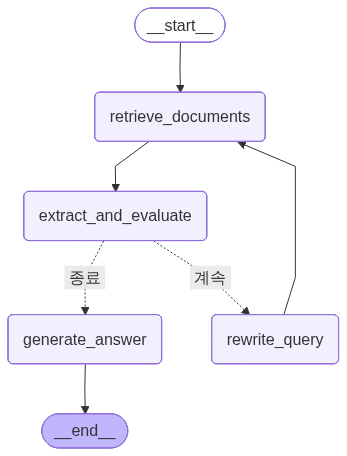


✅ [완료] Guideline Agent 그래프 구조 시각화 완료 ✅

📊 Guideline Workflow 구조:

START → retrieve_documents → extract_and_evaluate
 ├─(계속)→ rewrite_query → retrieve_documents
 └─(종료)→ generate_answer → END



In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal, List, Dict
from pprint import pprint
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import datetime
import re


# ======================================
# 1️⃣ GuidelineRagState 정의
# ======================================
class GuidelineRagState(QAState):
    """
    완성편입 전용 Guideline 검색용 상태 구조
    QAState를 확장하여 추가 필드 포함
    """
    rewritten_query: str              # 재작성된 검색 쿼리
    related_info: List[Dict]          # 추출된 정보 리스트
    node_answer: str                  # 최종 노드 답변
    num_generations: int              # 루프 반복 횟수
    sources: List[str]                # 최종 출처 리스트


# ======================================
# 2️⃣ 공통 로그 함수
# ======================================
def log(message: str, state: Dict = None):
    """시간 + 단계 + 상태 키 표시용 공용 로그 함수"""
    print(f"\n[{datetime.datetime.now().strftime('%H:%M:%S')}] {message}")
    if state:
        keys = ', '.join(list(state.keys()))
        print(f"  ↳ 현재 state keys: [{keys}]")


# ======================================
# 3️⃣ Guideline 문서 검색 단계
# ======================================
def retrieve_guideline_docs(state: GuidelineRagState) -> GuidelineRagState:
    """
    GuidelineDB의 [question] 컬럼을 기준으로 Embedding 검색 수행
    """
    log("==== [1단계] retrieve_guideline_docs (question을 기준으로 GuidelineDB에서 검색 수행) 시작 ====", state)

    query = state.get("rewritten_query", state["question"])
    print(f"📢 검색 쿼리 입력값: {query}")
    print("📚 검색 기준 필드: GuidelineDB의 [question] 컬럼 (임베딩 매칭)")

    docs = guideline_search.invoke(query)
    print(f"📄 검색 결과 문서 수: {len(docs)}")

    if len(docs) > 0:
        print("🧾 Top 1 검색 결과 미리보기:")
        preview_q = docs[0].page_content.split("\n")[0][:100]
        src_detail = docs[0].metadata.get("source_detail", "출처 미기재")
        print(f"   ▶ Q: {preview_q}")
        print(f"   ▶ 출처: {src_detail}")
    else:
        print("❗ 검색 결과가 없습니다. 쿼리를 재작성하거나 DB를 확인하세요.")

    # 출처 목록을 sources 필드에 저장
    sources = [
        f"{doc.metadata.get('source_name', 'GuidelineDB')} ({doc.metadata.get('source_detail', '출처 미기재')})"
        for doc in docs
    ]

    return {"search_results": docs, "sources": sources}


# ======================================
# 4️⃣ 문서 정보 추출 및 평가 단계
# ======================================
def extract_guideline_info(state: GuidelineRagState) -> GuidelineRagState:
    log("==== [2단계] extract_guideline_info (문서에서 관련 핵심정보 추출 및 평가) 시작 ====", state)
    extracted_list = []

    try:
        for i, doc in enumerate(state["search_results"]):
            print(f"\n🧾 {i+1}번째 문서 분석 중...")
            src_detail = doc.metadata.get("source_detail", "출처 미기재")
            print(f"   ▶ 출처: {src_detail}")

            doc_q = doc.page_content
            doc_a = doc.metadata.get("answer", "")
            print(f"   Q: {doc_q[:100]}")
            print(f"   A: {doc_a[:100]}")

            prompt = ChatPromptTemplate.from_messages([
                ("system", """당신은 대학 편입 모집요강 전문가입니다.
                아래 Q/A 문서에서 학생 질문과 관련된 주요 사실을 3~5개 정도 추출하세요. 
                각 항목은 다음과 같은 형식을 따릅니다:

                1. [추출된 정보 요약]
                - 질문과 관련성: 0~1 사이 숫자
                - 충실성 점수: 0~1 사이 숫자
                """),
                ("human", "질문: {question}\n\n[문서]\nQ: {q}\nA: {a}")
            ])
            formatted = prompt.format(question=state["question"], q=doc_q, a=doc_a)
            result = llm.invoke(formatted)

            if not result or not result.content.strip():
                print("⚠️ LLM 결과 없음 → 문서 스킵")
                continue

            # --- 점수 추출 ---
            text = result.content.strip()
            relevance_scores = [float(x) for x in re.findall(r"관련성\s*점수\s*[:：]?\s*([0-9]*\.?[0-9]+)", text)]
            faithfulness_scores = [float(x) for x in re.findall(r"충실성\s*점수\s*[:：]?\s*([0-9]*\.?[0-9]+)", text)]

            avg_rel = sum(relevance_scores)/len(relevance_scores) if relevance_scores else 0
            avg_fai = sum(faithfulness_scores)/len(faithfulness_scores) if faithfulness_scores else 0

            print(f"   📊 평균 관련성: {avg_rel:.2f}, 평균 충실성: {avg_fai:.2f}")

            # --- 점수 기준 필터링 ---
            if avg_rel < 0.7 or avg_fai < 0.7:
                print("🚫 점수가 낮아 제외됨 (기준: 0.7 이상)")
                continue

            extracted_list.append({
                "content": text,
                "source": src_detail,
                "avg_relevance": avg_rel,
                "avg_faithfulness": avg_fai
            })

        if len(extracted_list) == 0:
            print("❗ 관련 정보가 추출되지 않았거나 점수 기준 미달입니다.")

        log("✅ 정보 추출 및 필터링 완료", {"추출된 정보 개수": len(extracted_list)})
        return {
            "related_info": extracted_list,
            "num_generations": state.get("num_generations", 0) + 1
        }

    except Exception as e:
        print(f"❌ [오류] extract_guideline_info 실패: {e}")
        return {"related_info": [], "num_generations": 0}


# ======================================
# 5️⃣ 검색 쿼리 재작성 단계
# ======================================
def rewrite_guideline_query(state: GuidelineRagState) -> GuidelineRagState:
    """
    정보 부족 시, LLM을 통해 검색 쿼리 재작성 수행
    """
    log("==== [3단계] rewrite_guideline_query (검색 쿼리 재작성) 시작 ====", state)
    info_text = "\n".join([i["content"] for i in state["related_info"]])

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 대학 편입 전문 상담가입니다.
        아래 질문과 추출된 정보를 참고하여 더 구체적이고 정확한 검색 쿼리를 다시 작성하세요.
        - 핵심 키워드: 학교명, 학과명, 지원유형(일반/학사), 과목, 일정
        - 한 줄로 간결하게 작성
        """),
        ("human", "질문: {question}\n\n추출된 정보:\n{info}")
    ])

    rewritten = llm.invoke(rewrite_prompt.format(question=state["question"], info=info_text))
    new_query = rewritten.content.strip()

    print(f"💡 재작성된 쿼리: {new_query}")
    return {"rewritten_query": new_query}


# ======================================
# 6️⃣ 최종 답변 생성 단계
# ======================================
def generate_guideline_answer(state: GuidelineRagState) -> GuidelineRagState:
    """
    모든 추출 정보를 종합해 학생 질문에 대한 최종 답변 생성
    """
    log("==== [4단계] generate_guideline_answer (최종 답변 생성) 시작 ====", state)

    # 정보 병합 및 출처 표시
    info_text = "\n".join([f"- {i['content']} (출처: {i['source']})" for i in state["related_info"]])
    source_summary = "\n".join([f"- {s}" for s in state.get("sources", [])])

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 대학 편입 모집요강 전문 상담가입니다.
        학생의 질문과 관련 정보를 종합하여 답변을 작성하세요.
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다.
        출력 구조:
        1. 핵심 요약
        2. 세부 내용
        3. 참고 출처
        """),
        ("human", "질문: {question}\n\n관련 정보:\n{info}\n\n참고 출처:\n{src}")
    ])

    answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        info=info_text,
        src=source_summary
    ))

    print("🗒️ 생성된 답변 미리보기:\n", answer.content[:300], "...")
    log("✅ 최종 답변 생성 완료")
    return {"node_answer": answer.content, "sources": state.get("sources", [])}


# ======================================
# 7️⃣ 판단 단계
# ======================================
def should_continue_guideline(state: GuidelineRagState) -> Literal["계속", "종료"]:
    """
    정보 충분 여부에 따라 그래프 진행 방향 결정
    """
    log("==== [판단단계] should_continue_guideline (정보 충족 여부 판단) ====", state)
    print("📊 현재 related_info 개수:", len(state.get("related_info", [])))
    print("🔢 현재 반복 횟수:", state.get("num_generations", 0))

    gen = state.get("num_generations", 0)
    info_count = len(state.get("related_info", []))

    if gen >= 2:
        print("🔁 반복 횟수 초과 → 종료")
        return "종료"

    if info_count > 0:
        print(f"📈 충분한 정보 확보 ({info_count}개) → 종료")
        return "종료"

    print("🔄 정보 부족 → 쿼리 재작성 후 재검색")
    return "계속"


# ======================================
# 8️⃣ 그래프 구성 및 컴파일
# ======================================
log("🚀 [초기화] LangGraph Guideline Search Workflow 구성 시작")

guideline_graph = StateGraph(GuidelineRagState)

guideline_graph.add_node("retrieve", retrieve_guideline_docs)
guideline_graph.add_node("extract", extract_guideline_info)
guideline_graph.add_node("rewrite", rewrite_guideline_query)
guideline_graph.add_node("answer", generate_guideline_answer)

guideline_graph.add_edge(START, "retrieve")
guideline_graph.add_edge("retrieve", "extract")

guideline_graph.add_conditional_edges(
    "extract",
    should_continue_guideline,
    {"계속": "rewrite", "종료": "answer"}
)

guideline_graph.add_edge("rewrite", "retrieve")
guideline_graph.add_edge("answer", END)

guideline_agent = guideline_graph.compile()
log("✅ [완료] Guideline Agent 컴파일 완료")


# ======================================
# 🎯 완성편입 Guideline Graph (표준 노드명 버전)
# ======================================

# 그래프 생성
workflow = StateGraph(GuidelineRagState)

# 노드 추가 (표준화된 이름 사용)
workflow.add_node("retrieve_documents", retrieve_guideline_docs)       # GuidelineDB 검색
workflow.add_node("extract_and_evaluate", extract_guideline_info)      # 정보 추출 및 점수 평가
workflow.add_node("rewrite_query", rewrite_guideline_query)            # 검색 쿼리 재작성
workflow.add_node("generate_answer", generate_guideline_answer)        # 최종 답변 생성

# 엣지 연결
workflow.add_edge(START, "retrieve_documents")
workflow.add_edge("retrieve_documents", "extract_and_evaluate")

# 조건부 엣지 연결
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue_guideline,  # 판단 로직
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)

# 루프: 쿼리 재작성 후 다시 검색
workflow.add_edge("rewrite_query", "retrieve_documents")

# 최종 답변 후 종료
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
guideline_agent = workflow.compile()

# ======================================
# 🧭 그래프 시각화
# ======================================
display(Image(guideline_agent.get_graph().draw_mermaid_png()))
print("\n✅ [완료] Guideline Agent 그래프 구조 시각화 완료 ✅")

# ======================================
# 🌐 트리 구조 텍스트 로그
# ======================================
print("\n📊 Guideline Workflow 구조:")
print("""
START → retrieve_documents → extract_and_evaluate
 ├─(계속)→ rewrite_query → retrieve_documents
 └─(종료)→ generate_answer → END
""")



In [ ]:
# 테스트 입력 예시
inputs = {
    "question": "중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?",
    "student_profile": {"target_university": "중앙대학교", "track": "이과"}
}

# 스트리밍 실행 (각 노드별 진행 로그 확인)
print("\n===== 🚀 Guideline Graph 테스트 실행 =====\n")
for output in guideline_agent.stream(inputs):
    for key, value in output.items():
        print(f"\n🧩 [노드: {key}] 실행 결과:")
        pprint(value)
    print("\n------------------------------------\n")

print("\n✅ 최종 답변:")
print(value["node_answer"])


### 3-3 Web 검색 기반 RAG 에이전트
- search_web 노드 
- 위에 제작한 tool 사용

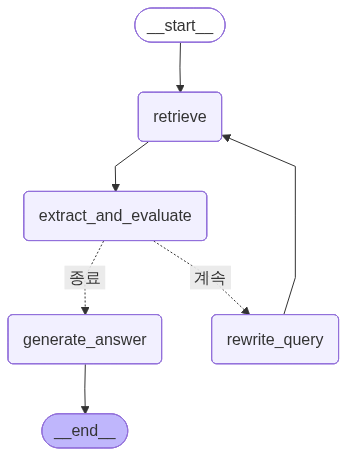


✅ [완료] 웹 검색 기반 RAG 에이전트 구성 완료


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal, Optional, List
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field

# ==============================
# 0️⃣ Pydantic 스키마 정의 (필수!)
# ==============================
class InformationStrip(BaseModel):
    """추출된 정보 조각"""
    content: str = Field(description="추출된 정보 내용")
    relevance_score: float = Field(description="질문과의 관련성 점수 (0-1)")
    faithfulness_score: float = Field(description="답변의 충실성 점수 (0-1)")
    source: str = Field(default="출처 미상", description="정보 출처 URL")

class ExtractedInformation(BaseModel):
    """문서에서 추출된 전체 정보"""
    strips: List[InformationStrip] = Field(description="추출된 정보 조각 리스트")
    query_relevance: float = Field(description="문서 전체의 질문 관련성 (0-1)")

class RefinedQuestion(BaseModel):
    """재작성된 검색 쿼리"""
    question_refined: str = Field(description="개선된 검색 쿼리")
    reason: str = Field(default="", description="재작성 이유")

# ==============================
# 1️⃣ SearchRagState 정의
# ==============================
class SearchRagState(QAState):
    rewritten_query: Optional[str] = None          # 재작성한 질문
    documents: Optional[List] = None               # 검색된 문서 리스트 ✅ 추가!
    extracted_info: Optional[List] = None          # 추출된 정보 조각 리스트
    node_answer: Optional[str] = None              # 최종 답변
    num_generations: int = 0                       # 반복 횟수


# ==============================
# 2️⃣ 문서 검색 단계
# ==============================
def retrieve_documents(state: SearchRagState) -> SearchRagState:
    print("🌐 --- [1단계] 문서 검색 ---")
    query = state.get("rewritten_query", state["question"])
    print(f"🔎 검색 쿼리: {query}")
    docs = web_search.invoke(query)
    print(f"📄 검색 결과 문서 수: {len(docs)}")
    return {"documents": docs}


# ==============================
# 3️⃣ 정보 추출 및 평가 단계
# ==============================
def extract_and_evaluate_information(state: SearchRagState) -> SearchRagState:
    print("🧩 --- [2단계] 정보 추출 및 평가 ---")

    # ✅ 안전하게 documents 가져오기
    docs = state.get("documents", [])
    if not docs:
        print("❗ 문서가 없습니다.")
        return {"extracted_info": [], "num_generations": state.get("num_generations", 0) + 1}

    extracted_strips = []
    MAX_DOC_LENGTH = 3000  # 🔒 문서 최대 길이 제한 (메모리 보호)

    for idx, doc in enumerate(docs[:3]):  # 🔒 최대 3개 문서만 처리
        print(f"\n📘 문서 {idx+1}/{len(docs[:3])} 분석 중...")
        
        try:
            # 🔒 문서 내용 길이 제한 (메모리 과부하 방지)
            doc_content = doc.page_content[:MAX_DOC_LENGTH]
            if len(doc.page_content) > MAX_DOC_LENGTH:
                print(f"⚠️ 문서가 너무 큽니다. {MAX_DOC_LENGTH}자로 자름")
            
            extract_prompt = ChatPromptTemplate.from_messages([
                ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 최대 3개만 간결하게 추출하세요. 
                각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
                1. 질문과 관련성
                2. 답변의 충실성
                
                마지막으로, 문서 전체의 질문 관련성을 0에서 1 사이의 점수로 평가하세요."""),
                ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
            ])

            extract_llm = llm.with_structured_output(ExtractedInformation)
            
            extracted_data = extract_llm.invoke(extract_prompt.format(
                question=state["question"],
                document_content=doc_content
            ))

            print(f"   📊 문서 관련성: {extracted_data.query_relevance:.2f}")
            
            if extracted_data.query_relevance < 0.7:  # 기준 완화 (0.8 → 0.7)
                print("   ⚠️ 문서 관련성 낮음 → 제외")
                continue

            for strip in extracted_data.strips:
                if strip.relevance_score >= 0.7 and strip.faithfulness_score >= 0.7:
                    strip.source = doc.metadata.get("source_url", doc.metadata.get("url", "출처 미상"))
                    extracted_strips.append(strip)
                    print(f"   ✅ 정보 추출: {strip.content[:50]}...")
        
        except Exception as e:
            print(f"   ❌ 문서 처리 오류: {str(e)[:100]}")
            continue  # 오류 발생 시 다음 문서로

    print(f"\n✅ 총 추출된 정보 개수: {len(extracted_strips)}")

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }


# ==============================
# 4️⃣ 쿼리 재작성 단계
# ==============================
def rewrite_query(state: SearchRagState) -> SearchRagState:
    print("🪄 --- [3단계] 쿼리 재작성 ---")

    extracted_info_str = "\n".join([strip.content for strip in state.get("extracted_info", [])])

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 질문과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}")
    ])

    rewrite_llm = llm.with_structured_output(RefinedQuestion)
    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    print(f"💡 재작성된 쿼리: {response.question_refined}")
    return {"rewritten_query": response.question_refined}


# ==============================
# 5️⃣ 최종 답변 생성 단계
# ==============================
def generate_node_answer(state: SearchRagState) -> SearchRagState:
    print("🧠 --- [4단계] 답변 생성 ---")

    extracted_info_str = "\n".join([
        f"- {strip.content} (출처: {strip.source}, 관련성: {strip.relevance_score:.2f}, 충실성: {strip.faithfulness_score:.2f})"
        for strip in state.get("extracted_info", [])
    ])

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 출처 및 링크
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 블로그 (www.blog.com/page/001)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}")
    ])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    print("📝 생성된 답변 미리보기:\n", node_answer.content[:300], "...")
    return {"node_answer": node_answer.content}


# ==============================
# 6️⃣ 반복 판단 단계
# ==============================
def should_continue(state: SearchRagState) -> Literal["계속", "종료"]:
    if state["num_generations"] >= 2:
        print("🔁 반복 횟수 초과 → 종료")
        return "종료"
    if len(state.get("extracted_info", [])) >= 1:
        print("✅ 충분한 정보 확보 → 종료")
        return "종료"
    print("🔄 정보 부족 → 쿼리 재작성 후 재검색")
    return "계속"


# ==============================
# 7️⃣ LangGraph 구성
# ==============================
workflow = StateGraph(SearchRagState)

workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {"계속": "rewrite_query", "종료": "generate_answer"}
)

workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 컴파일 및 시각화
search_web_agent = workflow.compile()
display(Image(search_web_agent.get_graph().draw_mermaid_png()))
print("\n✅ [완료] 웹 검색 기반 RAG 에이전트 구성 완료")


In [ ]:
# =========================================
# 🧪 Search Web Agent 실행 예시
# =========================================

# 테스트 입력
inputs = {
    "question": "2025학년도 중앙대학교 편입 시험 일정은 언제였나요?"
}

print("\n===== 🚀 웹 검색 RAG 테스트 시작 =====\n")

# LangGraph 에이전트 스트리밍 실행 (각 노드별 진행 로그 출력)
for output in search_web_agent.stream(inputs):
    for key, value in output.items():
        print(f"\n🧩 [노드: {key}] 실행 결과:")
        print("-" * 40)
        pprint(value)
    print("\n------------------------------------\n")

# 마지막 노드 결과 출력
print("\n✅ 최종 답변:")
print(value["node_answer"])


### 4. 질문 라우팅 
- 사용자의 질문을 분석하여 적절한 에이전트를 선택 (Adaptive RAG 적용)
- 위에서 정의한 2개의 에이전트 중 선택

In [24]:
from typing import Annotated
from operator import add
from pydantic import BaseModel, Field

# ======================================
# 통합 에이전트 상태 정의 (✅ prepare_context 활용)
# ======================================
class IntegratedAgentState(TypedDict):
    question: str
    student_profile: Dict[str, str]           # 🆕 학생 프로필
    recent_dialogues: List[Dict[str, str]]    # 🆕 최근 대화 내역
    context: str                              # 🆕 prepare_context로 생성
    answers: Annotated[List[str], add]
    final_answer: str
    datasources: List[str]

# ======================================
# 라우팅 결정을 위한 데이터 모델
# ======================================
class ToolSelector(BaseModel):
    """Routes the user question to the most appropriate tool."""
    tool: Literal["search_guideline", "search_web"] = Field(
        description="Select one of the tools, based on the user's question.",
    )

class ToolSelectors(BaseModel):
    """Select the appropriate tools that are suitable for the user question."""
    tools: List[ToolSelector] = Field(
        description="Select one or more tools, based on the user's question.",
    )

# 구조화된 출력을 위한 LLM 설정
structured_llm_tool_selector = llm.with_structured_output(ToolSelectors)

# 라우팅을 위한 프롬프트 템플릿
system = """당신은 대학 편입 상담 전문 AI 어시스턴트입니다. 
다음 가이드라인에 따라 사용자 질문을 적절한 도구로 라우팅하세요:

- 특정 대학의 편입 모집요강, 시험 과목, 전형 방법 등 내부 가이드라인DB에 있을만한 질문은 search_guideline 도구를 사용하세요.
- 최신 정보, 입시 일정, 합격자 발표, 또는 가이드라인DB에 없을 것 같은 정보는 search_web 도구를 사용하세요.
- 질문이 애매하거나 두 가지 모두 필요한 경우, 두 도구를 모두 선택하세요.

항상 사용자 질문에 가장 적합한 도구를 선택하세요."""

route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}"),
])

# 질문 라우터 정의
question_tool_router = route_prompt | structured_llm_tool_selector

print("✅ 질문 라우터 설정 완료")


✅ 질문 라우터 설정 완료


In [25]:
# ======================================
# 컨텍스트 준비 노드 (✅ 원래 prepare_context 함수 재사용)
# ======================================
def prepare_context_node(state: IntegratedAgentState) -> IntegratedAgentState:
    """
    학생 프로필과 최근 대화 내역을 종합하여 context 생성
    (Cell 6의 원래 prepare_context 로직 기반)
    """
    print("\n📋 --- 컨텍스트 준비 중 ---")
    
    # 학생 프로필 불러오기
    profile = state.get("student_profile", {})
    target_uni = profile.get("target_university", "미정")
    # 'track' 또는 'major_category' 모두 지원
    track = profile.get("track", profile.get("major_category", "계열 미지정"))
    
    # 최근 대화 내역 가져오기 (학생과 선생님 5개 정도)
    dialogues = state.get("recent_dialogues", [])
    dialogue_summary = " ".join(
        [f"{d['role']}: {d['message']}" for d in dialogues[-5:]]
    )
    
    # 질문과 맥락 결합
    context = (
        f"[학생 프로필] 목표 대학: {target_uni}, 계열: {track}\n"
        f"[최근 대화 요약] {dialogue_summary}\n"
        f"[학생 질문] {state['question']}"
    )
    
    print(f"✅ 컨텍스트 생성 완료")
    print(f"   - 목표 대학: {target_uni}")
    print(f"   - 계열: {track}")
    print(f"   - 대화 내역: {len(dialogues)}개")
    
    return {"context": context}


# ======================================
# 질문 라우팅 노드 정의
# ======================================
def analyze_question_tool_search(state: IntegratedAgentState):
    """사용자 질문을 분석하여 적절한 도구를 선택"""
    question = state["question"]
    context = state.get("context", "")
    
    print(f"\n🔍 질문 분석 중: {question}")
    
    # 컨텍스트 포함하여 분석 (더 정확한 라우팅)
    query = f"{context}\n\n질문: {question}" if context else question
    result = question_tool_router.invoke({"question": query})
    datasources = [tool.tool for tool in result.tools]
    print(f"📌 선택된 도구: {datasources}")
    return {"datasources": datasources}


def route_datasources_tool_search(state: IntegratedAgentState) -> List[str]:
    """선택된 데이터 소스에 따라 라우팅"""
    datasources = set(state['datasources'])
    valid_sources = {"search_guideline", "search_web"}
    
    if datasources.issubset(valid_sources):
        return list(datasources)
    
    return list(valid_sources)


# ======================================
# 서브 에이전트 노드 정의 (✅ 컨텍스트 활용)
# ======================================
def guideline_rag_node(state: IntegratedAgentState) -> IntegratedAgentState:
    """GuidelineDB 검색 에이전트 실행 (컨텍스트 포함)"""
    print("\n--- 📚 GuidelineDB 검색 에이전트 시작 ---")
    question = state["question"]
    context = state.get("context", "")
    
    try:
        # 컨텍스트와 함께 질문 전달
        enriched_question = f"{context}\n\n질문: {question}" if context else question
        
        # 타임아웃 설정 및 안전한 호출
        answer = guideline_agent.invoke(
            {"question": enriched_question},
            config={"recursion_limit": 10}  # 🔒 재귀 제한
        )
        print("✅ GuidelineDB 검색 완료")
        
        # 안전하게 답변 추출
        node_answer = answer.get("node_answer", "")
        if not node_answer:
            node_answer = "GuidelineDB에서 관련 정보를 찾을 수 없습니다."
        else:
            # 출처 정보 추가
            node_answer = f"[GuidelineDB 검색 결과]\n{node_answer}"
            
        return {"answers": [node_answer]}
        
    except Exception as e:
        print(f"❌ GuidelineDB 검색 오류: {str(e)[:100]}")
        return {"answers": ["GuidelineDB 검색 중 오류가 발생했습니다."]}


def web_rag_node(state: IntegratedAgentState) -> IntegratedAgentState:
    """웹 검색 에이전트 실행 (컨텍스트 포함)"""
    print("\n--- 🌐 웹 검색 에이전트 시작 ---")
    question = state["question"]
    context = state.get("context", "")
    
    try:
        # 컨텍스트와 함께 질문 전달
        enriched_question = f"{context}\n\n질문: {question}" if context else question
        
        # 타임아웃 설정 및 안전한 호출
        answer = search_web_agent.invoke(
            {"question": enriched_question},
            config={"recursion_limit": 10}  # 🔒 재귀 제한
        )
        print("✅ 웹 검색 완료")
        
        # 안전하게 답변 추출
        node_answer = answer.get("node_answer", "")
        if not node_answer:
            node_answer = "웹 검색에서 관련 정보를 찾을 수 없습니다."
        else:
            # 출처 정보 추가
            node_answer = f"[웹 검색 결과]\n{node_answer}"
            
        return {"answers": [node_answer]}
        
    except Exception as e:
        print(f"❌ 웹 검색 오류: {str(e)[:100]}")
        return {"answers": ["웹 검색 중 오류가 발생했습니다."]}


# ======================================
# 최종 답변 생성 노드
# ======================================
from langchain_core.output_parsers import StrOutputParser

# RAG 프롬프트 정의
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 대학 편입 전문 상담가입니다. 제공된 정보를 바탕으로 학생의 질문에 답변하세요.

다음 가이드라인을 따르세요:
1. 제공된 문서의 정보만 사용하세요.
2. 문서에 관련 정보가 부족하면 "제공된 정보로는 충분한 답변을 할 수 없습니다"라고 말하세요.
3. 각 문장마다 정보의 출처를 명시하세요. 형식:
   - GuidelineDB: "(출처 GuidelineDB (출처명))"
   - 웹 검색: "(출처 제목 (URL))"
4. 추측하거나 문서에 없는 정보를 추가하지 마세요.
5. 친절한 선생님의 말투로 학생들에게 직접 과외하듯 답변하되 필요없는 서론은 제외하고 본론만 간결하고 명확하게 작성하세요.
6. 불필요한 정보는 생략하세요.
7. 여러 출처에서 같은 정보를 제공하면 모든 관련 출처를 인용하세요.
8. 여러 출처의 정보를 결합할 때는 각 출처를 인용하면서 일관되게 작성하세요.
9. 어떤 정보를 통해서 답변을 만들거나 AI 툴을 활용하는 것을 알아차리지 못하도록 온전히 사람이 직접 생각해서 답변한 것처럼 해주세요. (제공된 정보에 의하면~ 와 같은 말 사용 금지)
10. 특수문자를 사용하지 말고 사람이 말하듯 한 문단으로 작성해주세요.

출처 인용 예시:
"중앙대학교 이과 편입은 수학 시험만 응시합니다 (GuidelineDB (cau2025-page7)). 시험 일정은 2025년 1월 18일입니다 (중앙대 편입 모집요강, https://example.com)."
"""),
    ("human", "다음 문서를 사용하여 질문에 답변하세요:\n\n[문서]\n{documents}\n\n[질문]\n{question}"),
])


def answer_final(state: IntegratedAgentState) -> IntegratedAgentState:
    """수집된 정보를 종합하여 최종 답변 생성 (컨텍스트 활용)"""
    print("\n--- 📝 최종 답변 생성 중 ---")
    question = state["question"]
    context = state.get("context", "")
    documents = state.get("answers", [])
    
    if not isinstance(documents, list):
        documents = [documents]

    # 문서 내용을 문자열로 결합
    documents_text = "\n\n".join(documents)
    
    # 컨텍스트와 함께 최종 질문 생성
    enriched_question = f"{context}\n\n질문: {question}" if context else question

    # RAG generation
    rag_chain = rag_prompt | llm | StrOutputParser()
    generation = rag_chain.invoke({
        "documents": documents_text, 
        "question": enriched_question
    })
    print("✅ 최종 답변 생성 완료")
    return {"final_answer": generation, "question": question}


print("✅ 노드 정의 완료")


✅ 노드 정의 완료


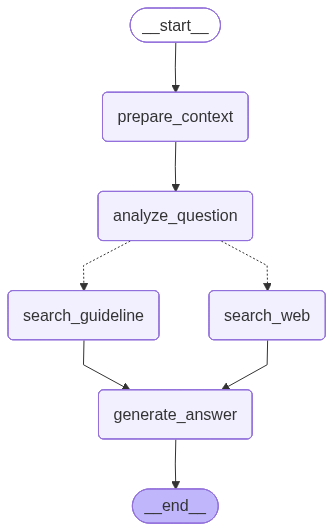


✅ [완료] 통합 에이전트 구성 완료 (prepare_context 포함)


In [26]:
# ======================================
# 통합 그래프 구성 (✅ prepare_context 포함)
# ======================================
# LangGraph의 StateGraph, START, END 노드 임포트
from langgraph.graph import StateGraph, START, END

# ======================================
# 노드 정의를 딕셔너리로 관리
# - 노드 이름(key)과 실행 함수(value)를 매핑
# ======================================
nodes = {
    "prepare_context": prepare_context_node,           # 컨텍스트 준비: 학생 프로필 + 대화 내역 → context 생성
    "analyze_question": analyze_question_tool_search,  # 질문 분석: LLM이 질문을 분석하여 적절한 도구 선택 (GuidelineDB / Web)
    "search_guideline": guideline_rag_node,            # GuidelineDB 검색: 내부 DB에서 편입 정보 검색
    "search_web": web_rag_node,                        # 웹 검색: Tavily API로 최신 정보 검색
    "generate_answer": answer_final,                   # 최종 답변 생성: 수집된 정보를 종합하여 답변 생성
}

# ======================================
# 그래프 생성: IntegratedAgentState를 상태로 사용
# - 모든 노드가 이 상태 구조를 공유함
# ======================================
integrated_builder = StateGraph(IntegratedAgentState)

# ======================================
# 노드 추가: 딕셔너리에 정의된 모든 노드를 그래프에 등록
# ======================================
for node_name, node_func in nodes.items():
    integrated_builder.add_node(node_name, node_func)  # 각 노드를 그래프에 추가

# ======================================
# 엣지 추가 (병렬 처리 지원)
# ======================================

# 1️⃣ START → prepare_context
# - 워크플로우 시작: 가장 먼저 컨텍스트를 준비
# - 입력: question, student_profile, recent_dialogues
# - 출력: context (형식화된 컨텍스트 문자열)
integrated_builder.add_edge(START, "prepare_context")

# 2️⃣ prepare_context → analyze_question
# - 컨텍스트 준비 완료 후 질문 분석 단계로 이동
# - LLM이 컨텍스트와 질문을 분석하여 어떤 도구를 사용할지 결정
integrated_builder.add_edge("prepare_context", "analyze_question")

# 3️⃣ analyze_question → 조건부 라우팅 (도구 선택)
# - route_datasources_tool_search 함수가 반환한 도구로 라우팅
# - 반환 가능한 값: ["search_guideline"], ["search_web"], ["search_guideline", "search_web"]
# - 두 개가 선택되면 병렬로 실행됨!
integrated_builder.add_conditional_edges(
    "analyze_question",                      # 출발 노드
    route_datasources_tool_search,           # 라우팅 결정 함수 (어느 노드로 갈지 결정)
    ["search_guideline", "search_web"]       # 가능한 목적지 노드 리스트
)

# 4️⃣ 검색 노드들을 generate_answer에 연결
# - search_guideline과 search_web 모두 generate_answer로 연결
# - 병렬 실행 가능: 두 검색이 동시에 진행되고 모두 완료되면 generate_answer 실행
# - answers 필드는 Annotated[List[str], add]로 정의되어 자동으로 병합됨
for node in ["search_guideline", "search_web"]:
    integrated_builder.add_edge(node, "generate_answer")

# 5️⃣ generate_answer → END
# - 최종 답변 생성 후 워크플로우 종료
# - 출력: final_answer (학생에게 제공할 최종 답변)
integrated_builder.add_edge("generate_answer", END)

# ======================================
# 그래프 컴파일
# - StateGraph를 실행 가능한 객체로 변환
# - 이후 integrated_agent.invoke()로 실행 가능
# ======================================
integrated_agent = integrated_builder.compile()

# ======================================
# 그래프 시각화
# - Mermaid 다이어그램으로 워크플로우 구조 표시
# ======================================
display(Image(integrated_agent.get_graph().draw_mermaid_png()))
print("\n✅ [완료] 통합 에이전트 구성 완료 (prepare_context 포함)")


In [27]:
# =========================================
# 🧪 통합 에이전트 테스트 실행 (✅ 컨텍스트 포함)
# =========================================

def test_integrated_agent(question: str, test_name: str, 
                          student_profile: Dict[str, str] = None,
                          recent_dialogues: List[Dict[str, str]] = None):
    """안전하게 통합 에이전트를 테스트 (컨텍스트 포함)"""
    print("\n" + "="*60)
    print(f"{test_name}")
    print("="*60)
    
    try:
        # 기본 학생 프로필 설정
        if student_profile is None:
            student_profile = {
                "target_university": "중앙대학교",
                "track": "이과"  # ✅ track 필드 사용 (Cell 6 기준)
            }
        
        # 기본 대화 내역 설정
        if recent_dialogues is None:
            recent_dialogues = [
                {"role": "student", "message": "아직 편입 공부를 시작하진 않았습니다."},
                {"role": "teacher", "message": "언제부터 공부 시작할 계획인가요?"},
                {"role": "student", "message": "다음 주부터 시작할 생각입니다."},
                {"role": "teacher", "message": "네 알겠습니다."},
                {"role": "student", "message": question}
            ]
        
        inputs = {
            "question": question,
            "student_profile": student_profile,
            "recent_dialogues": recent_dialogues
        }
        
        result = integrated_agent.invoke(
            inputs,
            config={
                "recursion_limit": 25,  # 🔒 전체 재귀 제한
                "timeout": 120  # 🔒 2분 타임아웃
            }
        )
        
        print("\n✅ 최종 답변:")
        print(result.get("final_answer", "답변을 생성하지 못했습니다."))
        return result
        
    except Exception as e:
        print(f"\n❌ 오류 발생: {str(e)[:200]}")
        return None


# 테스트 1: GuidelineDB 검색이 필요한 질문
test_integrated_agent(
    question="중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?",
    test_name="테스트 1: GuidelineDB 검색",
    student_profile={"target_university": "중앙대학교", "track": "이과"}  # ✅ track 필드 사용
)

# 테스트 2: 웹 검색이 필요한 질문  
test_integrated_agent(
    question="2025학년도 중앙대학교 편입 시험 일정은 언제였나요?",
    test_name="테스트 2: 웹 검색",
    student_profile={"target_university": "중앙대학교", "track": "이과"},
    recent_dialogues=[
        {"role": "student", "message": "편입 시험 일정이 궁금합니다."},
        {"role": "teacher", "message": "어느 대학을 알아보고 계신가요?"},
        {"role": "student", "message": "2025학년도 중앙대학교 편입 시험 일정은 언제였나요?"}
    ]
)

# 테스트 3: 두 가지 모두 필요할 수 있는 질문
test_integrated_agent(
    question="중앙대학교 이과 편입 시험 과목과 일정을 알려주세요",
    test_name="테스트 3: 복합 질문",
    student_profile={"target_university": "중앙대학교", "track": "이과"},
    recent_dialogues=[
        {"role": "student", "message": "편입 준비를 막 시작했습니다."},
        {"role": "teacher", "message": "어떤 정보가 필요하신가요?"},
        {"role": "student", "message": "중앙대학교 이과 편입 시험 과목과 일정을 알려주세요"}
    ]
)

print("\n" + "="*60)
print("✅ 모든 테스트 완료 (컨텍스트 활용)")
print("="*60)



테스트 1: GuidelineDB 검색

📋 --- 컨텍스트 준비 중 ---
✅ 컨텍스트 생성 완료
   - 목표 대학: 중앙대학교
   - 계열: 이과
   - 대화 내역: 5개

🔍 질문 분석 중: 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?
📌 선택된 도구: ['search_guideline']

--- 📚 GuidelineDB 검색 에이전트 시작 ---

[22:02:26] ==== [1단계] retrieve_guideline_docs (question을 기준으로 GuidelineDB에서 검색 수행) 시작 ====
  ↳ 현재 state keys: [question]
📢 검색 쿼리 입력값: [학생 프로필] 목표 대학: 중앙대학교, 계열: 이과
[최근 대화 요약] student: 아직 편입 공부를 시작하진 않았습니다. teacher: 언제부터 공부 시작할 계획인가요? student: 다음 주부터 시작할 생각입니다. teacher: 네 알겠습니다. student: 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?
[학생 질문] 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?

질문: 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?
📚 검색 기준 필드: GuidelineDB의 [question] 컬럼 (임베딩 매칭)

🔍 [GuidelineDB Hybrid Search] 쿼리: [학생 프로필] 목표 대학: 중앙대학교, 계열: 이과
[최근 대화 요약] student: 아직 편입 공부를 시작하진 않았습니다. teacher: 언제부터 공부 시작할 계획인가요? student: 다음 주부터 시작할 생각입니다. teacher: 네 알겠습니다. student: 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?
[학생 질문] 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?

질문: 중앙대학교 이과 편입은 어떤 과목을 준비해야 하나요?
   🔍 하이브리드 검색 시작...
   📌 추출된 키워드: ['[학생', '프로필]', '목표', '대학